In [1]:
import src.data_prep
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

%matplotlib inline


In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint 

In [3]:
ls

EDA.ipynb                        Untitled1.ipynb
README.md                        data/
Speech_Detection_Pipeline.ipynb  src/
Untitled.ipynb


# Organizing paths to audio and text files

In [3]:
audio_paths, texts = src.data_prep.get_audio_and_text_data('/Users/joshbernd/Desktop/gal_notes/Capstone/Speech_Detection/data/LibriSpeech_train/train-clean-100/')        


text file:  0
text file:  50
text file:  100
text file:  150
text file:  200
text file:  250
text file:  300
text file:  350
text file:  400
text file:  450
text file:  500
text file:  550


Here is how the data looks:

In [4]:
audio_paths[111]#, texts[111]

'/Users/joshbernd/Desktop/gal_notes/Capstone/Speech_Detection/data/LibriSpeech_train/train-clean-100/8580/287364/8580-287364-0003.flac'

## Let's store our phonemes and text for safe keeping

with open("data/ipa.txt", "w") as f:
    for t in texts:
        f.write(str(t) +"\n")

with open("data/audio_path.txt", "w") as f:
    for a in audio_paths:
        f.write(str(a) + "\n")

In [94]:
## reading in saved texts
texts = []
with open("data/ipa.txt", "r") as f:
  for line in f:
    texts.append(line.strip())

In [93]:
audio_list = []
with open('data/audio_path.txt', 'r') as f:
    for line in f:
        audio_list.append(line.strip())

## Train Test Split the data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(audio_paths, texts, test_size=0.33, random_state=42)

In [8]:
len(X_train), len(y_train)

(19121, 19121)

In [9]:
len(X_test), len(y_test)

(9418, 9418)

In [10]:
texts[0], audio_paths[0]

('hæd leɪd ˌbiˈfɔr hər ə pɛr əv ɔlˈtərnətɪvz naʊ əv kɔrs jʊr kəmˈplitli jʊr oʊn ˈmɪstrəs ənd ər ɛz fri ɛz ðə bərd ɔn ðə baʊ aɪ doʊnt min ju wər nɑt soʊ ˌbiˈfɔr bət jʊr æt ˈprɛzənt ɔn ə ˈdɪfərənt ˈfʊtɪŋ',
 '/Users/joshbernd/Desktop/gal_notes/Capstone/Speech_Detection/data/LibriSpeech_train/train-clean-100/1069/133709/1069-133709-0000.flac')

## Now that we have the paths to the .flac files, let's convert them to spectrograms

In [11]:
a = src.data_prep.spectrogram_from_file(audio_paths[0])

/usr/local/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [12]:
len(a)

1508

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=161, output_dim=46))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 46)          7406      
_________________________________________________________________
gru (GRU)                    (None, None, 256)         233472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 291,448
Trainable params: 291,448
Non-trainable params: 0
_________________________________________________________________


## Let's develop training pipeline and AudioGenerator Class

In [45]:
from src.data_prep import calc_feat_dim, spectrogram_from_file

In [16]:
def train_model(input_to_model, 
                pickle_path, 
                save_model_path, 
                train_data='data/audio_path.txt',
                validation_data="data/ipa.txt", 
                batch_size=20,
                optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                epochs=20,
                verbose=1):
    
    ## create audio_generator instance to get batches of audio
    audio_generator = AudioGenerator()
    audio_generator.load_train_data(train_data)
    audio_generator.load_validation_data(validation_data)
        


In [118]:
## make an audio generator
import warnings
warnings.filterwarnings("ignore")
                        
                        
class AudioGenerator():
    def __init__(self, audio, text, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, max_duration=10.0, 
        sort_by_duration=False):
        
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """
    
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.feats_mean = np.zeros((self.feat_dim))
        self.feats_std = np.ones((self.feat_dim,))
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.sort_by_duration = sort_by_duration
        
        self.train_audio = audio
        self.train_texts = texts
    
    def get_batch(self, partition):
        if partition == 'train':
            audio_paths = self.train_audio
            cur_index = self.cur_train_index
            texts = self.train_texts
#         elif partition == 'valid':
#             audio_paths = self.valid_audio_paths
#             cur_index = self.cur_valid_index
#             texts = self.valid_texts
#         elif partition == 'test':
#             audio_paths = self.test_audio_paths
#             cur_index = self.test_valid_index
#             texts = self.test_texts
            
#         features = [self.featurize(a) for a in audio_paths[0:0+self.minibatch_size]]
        features = [self.normalize(self.featurize(a)) for a in audio_paths[cur_index:cur_index+self.minibatch_size]]

#         calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])        
        
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        
        return spectrogram_from_file(
            audio_clip, step=self.step, window=self.window,
            max_freq=self.max_freq)


    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)
    

In [119]:
audiogen = AudioGenerator(audio_list, texts)

In [120]:
audiogen.get_batch('train')

In [121]:
audiogen.cur_train_index

0

In [72]:
spectrogram_from_file(
            audio_paths[0], step=2, window=20,
            max_freq=8000)

/usr/local/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


array([[-22.48421089, -16.57190144, -16.67293584, ..., -30.43931628,
        -31.12284719, -32.10825121],
       [-21.26560198, -16.77462512, -16.32569872, ..., -29.89971533,
        -31.06289731, -32.11658378],
       [-23.32860737, -16.46061368, -16.15647108, ..., -29.7657245 ,
        -31.0270008 , -32.15153424],
       ...,
       [-19.36308464, -17.04863938, -17.70896089, ..., -32.23022756,
        -32.2358838 , -32.23613255],
       [-17.98109631, -17.25473258, -18.40611363, ..., -32.23077581,
        -32.23605049, -32.23609093],
       [-17.63391478, -17.517414  , -20.05605094, ..., -32.22730854,
        -32.23538045, -32.23610779]])

-------

## Unrelated - nn practice with MNIST

In [11]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [12]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [14]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 10s 11ms/step - loss: 0.9320 - accuracy: 0.7105 - val_loss: 0.4911 - val_accuracy: 0.8500


Predicted result is: [3], target result is: 5


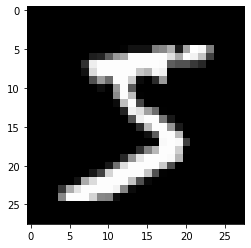

In [17]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

In [12]:
from keras.models import Model
from keras.layers import Input, GRU, Activation

In [15]:
def simple_rnn_model(input_dim, output_dim=46):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(output_dim, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [16]:
model_0 = simple_rnn_model(input_dim=161)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0         
_________________________________________________________________
rnn (GRU)                    (None, None, 46)          28842     
_________________________________________________________________
softmax (Activation)         (None, None, 46)          0         
Total params: 28,842
Trainable params: 28,842
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True)